# Package imports and preparations

In [35]:
cd /home/schlecker/repos/planeteScripts

/home/schlecker/repos/planeteScripts


In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import output
import plots
import stats
import utils

%load_ext autoreload
%autoreload 2

# default output folder
outputs = '/home/schlecker/phd/planete/outputs/'

# show more columns in pandas data frames
pd.set_option('display.max_columns', 500)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read in the data
We look at the system at t=5*10^9 yr.
- read this snapshot
- compute orbital period from Mstar and sma
- for each system, draw Msin(i)
- count the initial number of systems

In [37]:
rr5e9 = outputs + 'J34/ref_red5e9.dat'
j34 = output.Population(rr5e9)
pop = j34.data

In [38]:
# this is slow. 
pop['msini'] = np.nan
for i in pop.isystem:
    pop.loc[pop.isystem == i, 'msini'] = utils.get_sini()*pop[pop.isystem == i]['m']

In [39]:
pop = utils.get_orbitalPeriod(pop, MstarRel=1.)
Nsystems_initial = pop.isystem.nunique()
print("number of systems in this population: {}".format(Nsystems_initial))

number of systems in this population: 972


In [40]:
pop['msini'].describe()

count    48600.000000
mean        21.252596
std        273.069810
min          0.000060
25%          0.054639
50%          0.223008
75%          0.831225
max      14498.561681
Name: msini, dtype: float64

# General occurrences 
In this section, we investigate occurrences of the synthetic population in planet size/orbital period

In [41]:
pop.r_rEarth = utils.r_Jup2r_Earth(pop['r'])
pop.r_rEarth.describe()

count    48600.000000
mean        14.878256
std        184.485501
min          0.038336
25%          0.498626
50%          0.931980
75%          2.485066
max       9546.663622
Name: r, dtype: float64

using only planets with status "0"
Number of Systems: 972


Text(0.5,0,'Orbital Period [d]')

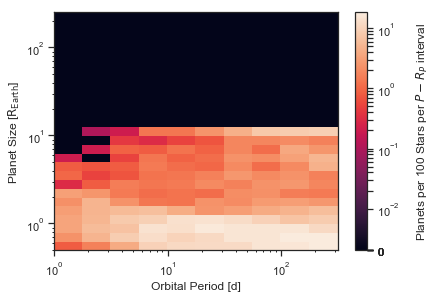

In [44]:
fig, ax = plt.subplots()
J34occ = plots.plot_occurrence(pop, ax=ax, xRange=(1.,300.), yRange=(0.5, 200.), kind='annotate', binWidth_dex=(0.25, 0.1), logColormap=True)

# workaround for axis labels
J34occ[3].set_xlabel('Orbital Period [d]')
# J34occ[3].annotate('Planet Size [$\mathrm{R_{Earth}}$]', xy=(0.05,0.5), xytext=(0.02, 0.5), xycoords='figure fraction', textcoords='figure fraction', rotation=90, verticalalignment='center', size='larger')

In [45]:
# save as eps to avoid white lines between histogram cells
fig.savefig(outputs + 'J34/j34occurrence.eps')

# Occurrences of different planet types

We categorize planets into Super Earths (SE) or Cold Jupiters (CJ) according to the rules in Zhu & Wu 2018 (including the requirement for RV semi-amplitude K > 3 m/s)

In [50]:
pop = stats.categorizePlanets(pop, ZhuWu18=True)
stats.print_categories(pop, Mgiant=95.)
Nsystems = pop.isystem.nunique()

giant mass Mgiant = 95.0
number of planets: 26919
number of ejected planets: 1349
Number of planets more massive than M_Earth: 6095
Number of planets more massive than M_Earth and ejected: 842
Number of planets more massive than M_giant: 629
Number of planets more massive than M_giant and ejected: 29


just quickly checking the radius distribution (in Jupiter radii!) of the giants

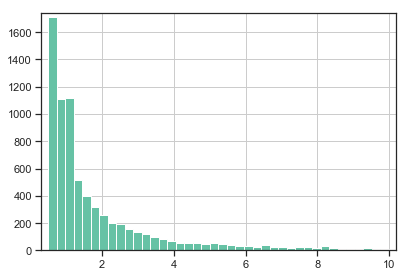

In [51]:
pop[(pop.r < 10) & (pop.r > 0.5)].r.hist(bins=40)

Extract CJ and SE from the population; count them

In [52]:
j34CJ = pop[pop['planetType'] == 'ColdJupiter']
j34SE = pop[pop['planetType'] == 'SuperEarth']
print('number of SE: {}'.format(len(j34SE)))
print('number of CJ: {}'.format(len(j34CJ)))
print('number of systems with SE: {}'.format(pop[pop['planetType'] == 'SuperEarth'].isystem.nunique()))
print('number of systems with CJ: {}'.format(pop[pop['planetType'] == 'ColdJupiter'].isystem.nunique()))

number of SE: 1104
number of CJ: 238
number of systems with SE: 396
number of systems with CJ: 188


check if the CJ really are CJ

In [ ]:
j34CJ.r.describe()

In [ ]:
j34CJ.plot.scatter('period', 'r')

the CJs are not very large, in fact they never go beyond ~1.1 Rjup.

# Occurrence Probabilities
### Probabilities of having a SE/CJ

In [ ]:
P_SE = j34SE.isystem.nunique()/Nsystems
P_CJ = j34CJ.isystem.nunique()/Nsystems
print(P_SE)
print(P_CJ)

### Probability of having neither a SE nor a CJ

In [ ]:
# create a mask that is True where there is either type of planet
SEorCJmask = {i: ((group['planetType'] == 'SuperEarth').any() | (group['planetType'] == 'ColdJupiter').any()) 
              for i, group in pop.groupby('isystem')}
NnoSEnoCJ = sum([not i for i in SEorCJmask.values()]); print(NnoSEnoCJ)
P_noSEnoCJ = NnoSEnoCJ/Nsystems; print(P_noSEnoCJ)

that is quite a high rate of noSEnoCJ. Let's check with an independent second count

In [ ]:
NnoSEnoCJ_2 = 0
for i, group in pop.groupby('isystem'):
    if (not 'ColdJupiter' in group.planetType.values) and (not 'SuperEarth' in group.planetType.values):
        NnoSEnoCJ_2 += 1
NnoSEnoCJ_2

OK, it is consistent.

### Probability of having both a SE *and* a CJ

In [ ]:
SEandCJmask = {i: ((group['planetType'] == 'SuperEarth').any() & (group['planetType'] == 'ColdJupiter').any()) 
               for i, group in pop.groupby('isystem')}
N_SEandCJ = sum([i for i in SEandCJmask.values()]); print(N_SEandCJ)
P_SEandCJ = N_SEandCJ/Nsystems; print(P_SEandCJ)

### Probability of having at least oneSE but _no_ CJ

In [ ]:
SEnoCJmask = {i: ((group['planetType'] == 'SuperEarth').any() & ~(group['planetType'] == 'ColdJupiter').any()) 
              for i, group in pop.groupby('isystem')}
N_SEnoCJ = sum([i for i in SEnoCJmask.values()]); print(N_SEnoCJ)
P_SEnoCJ = N_SEnoCJ/Nsystems; print(P_SEnoCJ)

### Probability of having _no_ SE but at least one CJ

In [ ]:
noSECJmask = {i: (~(group['planetType'] == 'SuperEarth').any() & (group['planetType'] == 'ColdJupiter').any()) 
              for i, group in pop.groupby('isystem')}
N_noSECJ = sum([i for i in noSECJmask.values()]); print(N_noSECJ)
P_noSECJ = N_noSECJ/Nsystems; print(P_noSECJ)

consistency check:

In [ ]:
print(P_noSECJ + P_SEnoCJ + P_noSEnoCJ + P_SEandCJ)

## Conditional probabilities

In [ ]:
len(pop[pop['planetType'] == 'ColdJupiter'].isystem.unique())

In [ ]:
# def get_probs(pop, uniqueSystem=True):
#     """ Calculate probabilities for certain planet types.
    
#     Parameters
#     ----------
#     pop : pandas DataFrame
#         population or subpopulation of planets. 
#         Can be multi-planet systems (has to include a column 'isystem')
#     uniqueSystem : Bool
#         get probabilities for unique systems, not just considering the whole 
#         bunch of planets
#     """
#     Nsystems = pop.isystem.nunique()    
#     Nplanets = len(pop)
    
#     j34CJ = pop[pop['planetType'] == 'ColdJupiter']
#     j34SE = pop[pop['planetType'] == 'SuperEarth']
    
#     # get systems containing >=1 SE/CJ
#     CJsystemNo = pop[pop['planetType'] == 'ColdJupiter'].isystem.unique()
#     SEsystemNo = pop[pop['planetType'] == 'SuperEarth'].isystem.unique()   
#     CJsystems = pop[pop.isystem.isin(CJsystemNo)]
#     SEsystems = pop[pop.isystem.isin(SEsystemNo)]
    
#     # P(SE|CJ)
    
    

In [ ]:
CJsystemNo = pop[pop['planetType'] == 'ColdJupiter'].isystem.unique()
SEsystemNo = pop[pop['planetType'] == 'SuperEarth'].isystem.unique()   
CJsystems = pop[pop.isystem.isin(CJsystemNo)]
SEsystems = pop[pop.isystem.isin(SEsystemNo)]
N_CJsystems = CJsystems.isystem.nunique()
N_SEsystems = SEsystems.isystem.nunique()

### What is the probability to have at least one SE(CJ) in a system with at leat one CJ(SE)?

In [ ]:
SEsInCJsystemsNo = CJsystems[CJsystems['planetType'] == 'SuperEarth'].isystem.unique()
CJsInSEsystemsNo = SEsystems[SEsystems['planetType'] == 'ColdJupiter'].isystem.unique()
SEsInCJsystems = CJsystems[CJsystems.isystem.isin(SEsInCJsystemsNo)]
CJsInSEsystems = SEsystems[SEsystems.isystem.isin(CJsInSEsystemsNo)]
N_SEsInCJsystems = SEsInCJsystems.isystem.nunique()
N_CJsInSEsystems = CJsInSEsystems.isystem.nunique()

these two sets should be the same, let's check this

In [ ]:
SEsInCJsystems.equals(CJsInSEsystems)

Compute P(SE|CJ) and P(CJ|SE)

In [ ]:
P_CJSE = N_CJsInSEsystems/N_SEsystems; print(P_CJSE)

P_SECJ = N_SEsInCJsystems/N_CJsystems; print(P_SECJ)

P(CJ|SE) is consistent with Zu&Wu, P(SE|CJ) is not (they find 0.9+=0.2, although in an indirect approach imposing Bayes' theorem)
___________________________
Compute P(noSE|CJ), i.e. the probability to have no SE in systems with at least one CJ (as in the Solar System)

and P(noCJ|SE)

In [ ]:
noSEsInCJsystems = CJsystems[~CJsystems.isystem.isin(SEsInCJsystemsNo)]
noCJsInSEsystems = SEsystems[~SEsystems.isystem.isin(CJsInSEsystemsNo)]
N_noSEsInCJsystems = noSEsInCJsystems.isystem.nunique()
N_noCJsInSEsystems = noCJsInSEsystems.isystem.nunique()

In [ ]:
P_noSECJ = N_noSEsInCJsystems/N_CJsystems; print(P_noSECJ)
P_noCJSE = N_noCJsInSEsystems/N_SEsystems; print(P_noCJSE)

Confirm P(noSE|CJ) with a different method

In [ ]:
N_CJsystems2 = 0
N_noSEinCJsystem = 0
for i, group in pop.groupby('isystem'):
    if (group.planetType == 'ColdJupiter').any():
        N_CJsystems2 += 1
        if not (group.planetType == 'SuperEarth').any():
            N_noSEinCJsystem += 1
print(N_noSEinCJsystem/N_CJsystems2)

In [ ]:
Nsystems

In [ ]:
# test msini dist
m = 1*np.ones(10000)
msini= utils.get_msini(m)
H = sns.distplot(msini)

In [ ]:
i = np.linspace(0.,np.pi/2, len(m))
plt.plot(i, np.sin(i))

fi = np.arcsin(utils.get_msini(m))
plt.hist(fi, normed=True)